# 1 практическое задание. Обучение полносвязной нейронной сети.

## Практикум на ЭВМ для 317 группы, весна 2019

#### Фамилия, имя: Попов Дмитрий

Дата выдачи: 19 февраля

Мягкий дедлайн: 28 февраля 23:59 

In [1]:
import numpy as np

In [2]:
import random, sys
my_seed = random.randrange(sys.maxsize) % 2**32
np.random.seed(my_seed)
my_seed

1139103331

## Реализация нейронной сети (6 баллов)

В этом задании вы обучите полносвязную нейронную сеть распознавать рукописные цифры (а что же еще, если не их :), [почти] самостоятельно реализовав все составляющие алгоритма обучения и предсказания.

Для начала нам понадобится реализовать прямой и обратный проход через слои. Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

In [3]:
class IdentityLayer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           
    output = layer.forward(input)
    
    - Propagate gradients through itself:    
    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters.
    
    Modified code from cs.hse DL course *
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) 
        and auxiliary stuff. You should enumerate all parameters
        in self.params"""
        # An identity layer does nothing
        self.params = []
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], 
        returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        self.input = input
        return input

    def backward(self, grad_output): 
        """
        Performs a backpropagation step through the layer, 
        with respect to the given input.
        
        To compute loss gradients w.r.t input, 
        you need to apply chain rule (backprop):
        
        d loss / d input  = (d loss / d layer) *  (d layer / d input)
        
        Luckily, you already receive d loss / d layer as input, 
        so you only need to multiply it by d layer / d x.
        
        The method returns:
        * gradient w.r.t input (will be passed to 
          previous layer's backward method)
        * flattened gradient w.r.t. parameters (with .ravel() 
          applied to each gradient). 
          If there are no params, return []
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = self.input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input), [] # chain rule

### Слой нелинейности ReLU

Для начала реализуем слой нелинейности $ReLU(x) = max(x, 0)$. Параметров у слоя нет. Метод forward должен вернуть результат поэлементного применения ReLU к входному массиву, метод backward - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить как атрибут класса.

In [4]:
class ReLU:
    """
    Modified code from cs.hse DL course *
    """
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        self.params = [] # ReLU has no parameters
        self.input = None
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, num_units] matrix"""
        ### your code here
        
        self.input = input
        return np.maximum(input, 0)
    
    def backward(self, grad_output):
        """Compute gradient of loss w.r.t. ReLU input
        grad_output shape: [batch, num_units]
        output 1 shape: [batch, num_units]
        output 2: []
        """
        ### your code here
        
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input, []
        

### Полносвязный слой
Далее реализуем полносвязный слой без нелинейности. У слоя два параметра: матрица весов и вектор сдвига.

Обратите внимание на второй аргумент: в нем надо возвращать градиент по всем параметрам в одномерном виде. Для этого надо сначала применить .ravel() ко всем градиентам, а затем воспользоваться  np.r_:

In [5]:
# example
np.r_[np.eye(3).ravel(), np.arange(4)]

array([1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 3.])

In [6]:
class Dense:
    """
    Modified code from cs.hse DL course *
    """
    def __init__(self, input_units, output_units):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = W x + b
        """
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        self.params = [self.weights, self.biases]
        
        self.input = None
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = W x + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        ### your code here
        
        self.input = input
        return np.dot(input, self.weights) + self.biases[None, :]
        
    
    def backward(self, grad_output):
        """
        compute gradients
        grad_output shape: [batch, output_units]
        output shapes: [batch, input_units], [num_params]
        
        hint: use function np.r_
        np.r_[np.arange(3), np.arange(3)] = [0, 1, 2, 0, 1, 2]
        """
        ### your code here
        
        grad_input = grad_output.dot(self.weights.T)
        grad_weights = self.input.T.dot(grad_output)
        grad_bias = grad_output.sum(axis=0)
        return grad_input, np.r_[grad_weights.ravel(), grad_bias.ravel()]
        

### Проверка градиента

Проверим правильность реализации с помощью функции численной проверки градиента. Функция берет на вход callable объект (функцию от одного аргумента-матрицы) и аргумент и вычисляет приближенный градиент функции в этой точке.

In [7]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

Вычислите аналитический и численный градиенты по входу слоя ReLU от функции
$$ f(y) = \sum_i y_i, \quad y = ReLU(x) $$

Следующая ячейка после заполнения должна не выдавать ошибку :)

In [8]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
### your code here
l = ReLU()

def loss(X):
    return l.forward(X).sum()

def loss_grad():
    return l.backward(np.ones([10, 12]))

### grads = 
y = loss(points)
grads, _ = loss_grad()

### numeric_grads = 
numeric_grads = eval_numerical_gradient(loss, points)

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

Вычислите аналитический и численный градиенты по входу полносвязного слоя от функции
$$ f(y) = \sum_i y_i, \quad y = W x + b $$

In [9]:
x = np.linspace(-1, 1, 10*12).reshape([10, 12])
l = Dense(12, 32,)

### your code here

def loss(X):
    return l.forward(X).sum()

def loss_grad():
    return l.backward(np.ones([10, 32]))

### grads = 
y = loss(points)
grads, _ = loss_grad()

### numeric_grads = 
numeric_grads = eval_numerical_gradient(loss, points)


assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

### Реализация softmax-слоя и функции потерь

Для решения задачи многоклассовой классификации обычно используют softmax в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:
$$\hat y = softmax(x)  = \bigl \{\frac {exp(x_i)}{\sum_j exp(x_j)} \bigr \}_{i=1}^K, \quad K - \text{число классов}$$
В этом случае удобно оптимизировать логарифм правдоподобия:
$$L(y, \hat y) = -\sum_{i=1}^K y_i \log \hat y_i \rightarrow \min,$$
где $y_i=1$, если объект принадлежит $i$-му классу, и 0 иначе. Записанная в таком виде, эта функция потерь совпадает с выражением для кросс-энтропии. Очевидно, что ее также можно переписать через индексацию, если через $y_i$ обозначить класс данного объекта:
$$L(y, \hat y) = - \log \hat y_{y_i} \rightarrow \min$$
В таком виде ее удобно реализовывать.

Реализуйте слой Softmax (без параметров). Метод forward должен вычислять логарифм от softmax, а метод backward - пропускать градиенты. В общем случае в промежуточных вычислениях backward получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде.  Поэтому мы будем предполагать, что аргумент grad_output - это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

In [10]:
from scipy.special import logsumexp
# use this function instead of np.log(np.sum(np.exp(...))) !
# because it is more stable

In [11]:
class Softmax:
    def __init__(self):
        self.params = []
        
        self.input = None
        self.logsoftmax = None
        
    def forward(self, input):
        """
        Applies softmax to each row and then applies component-wise log
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        """
        ### your code here
        
        self.input = input
        self.logsoftmax = input - logsumexp(input, axis=1)[:, None]
        return self.logsoftmax
        
    
    def backward(self, grad_output):
        """
        Propagartes gradients.
        Assumes that each row of grad_output contains only 1 
        non-zero element
        Input shape: [batch, num_units]
        Output shape: [batch, num_units]
        Do not forget to return [] as second value (grad w.r.t. params)
        """
        ### your code here
        
        softmax = np.exp(self.logsoftmax)
        grad_input = grad_output - softmax * grad_output.sum(1)[:, np.newaxis]
        return grad_input, []
        

Реализуйте функцию потерь и градиенты функции потерь. 

In [12]:
def crossentropy(activations, target):
    """
    returns negative log-likelihood of target under model represented by
    activations (log probabilities of classes)
    each arg has shape [batch, num_classes]
    output shape: 1 (scalar)
    """
    ### your code here
    
    return -activations[target > 0].sum()
    

def grad_crossentropy(activations, target):
    """
    returns gradient of negative log-likelihood w.r.t. activations
    each arg has shape [batch, num_classes]
    output shape: [batch, num-classes]
    
    hint: this is just one-hot encoding of target vector
          multiplied by -1
    """
    ### your code here
    
    return -target
    

Наконец, выполните проверку softmax-слоя, используя функцию потерь и ее градиент.  

In [13]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
target = np.arange(10)
### your code here

l = Softmax()

### make one hot target

ohe_target = np.zeros([10, 12])
ohe_target[np.arange(10), target] = 1

def loss(points):
    return crossentropy(l.forward(points), ohe_target)

def loss_grad(points):
    return l.backward(grad_crossentropy(l.forward(points), ohe_target))

### grads = 

y = loss(points)
grads, _ = loss_grad(points)


### numeric_grads = 

numeric_grads = eval_numerical_gradient(loss, points)

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

## Загрузка данных

Мы реализаовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом digits, каждый объект в котором - это 8x8 изображение рукописной цифры.

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from sklearn.datasets import load_digits

In [16]:
X, y = load_digits(return_X_y=True)

In [17]:
### make one hot target
ohe_y = np.zeros((X.shape[0], 10))
ohe_y[np.arange(X.shape[0]), y] = 1

In [18]:
X.shape, y.shape, ohe_y.shape

((1797, 64), (1797,), (1797, 10))

Разделим данные на обучение и контроль:

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test, ohe_y_train, ohe_y_test = train_test_split(X, y, ohe_y, random_state=0)

In [21]:
X_train.shape, X_test.shape

((1347, 64), (450, 64))

## Сборка и обучение нейронной сети (2 балла)

В нашей реализации нейросеть - это список слоев. Например:

In [22]:
network = []
hidden_layers_size = 32
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))
network.append(Softmax())

Для проверки, хорошо ли сеть обучилась, нам понадобится вычислять точность (accuracy) на данной выборке. Для этого реализуйте функцию, которая делает предсказания на каждом объекте:

In [23]:
def predict(network, X):
    """
    returns predictions for each object in X
    network: list of layers
    X: raw data
    X shape: [batch, features_num]
    output: array of classes, each from 0 to 9
    output shape: [batch]
    """
    ### your code here
    
    output = X
    for layer in network:
        output = layer.forward(output)
    return output

Мы будем обучать параметры нейросети с помощью готовой функции оптимизации из модуля scipy:

In [24]:
from scipy.optimize import minimize

In [25]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

Эта функция имеет стандартный интерфейс: нужно передать callable объект, который вычисляет значение и градиент целевой функции, а также точку старта оптимизации - начальное приближение (одномерный numpy-массив). Поэтому нам понадобятся функции для сбора и задания всех весов нашей нейросети (именно для них мы всегда записывали параметры слоя в список layer.params)

In [26]:
def get_weights(network):
    weights = []
    for layer in network:
        for param in layer.params:
            weights += param.ravel().tolist()
    return np.array(weights)

def set_weights(weights, network):
    i = 0
    for layer in network:
        for param in layer.params:
            l = param.size
            param[:] = weights[i:i+l].\
                             reshape(param.shape)
            i += l
        

Вам нужно реализовать ту самую функцию, которую мы будем передавать в minimize. Эта функция должна брать на вход текущую точку (вектор всех параметров), а также список дополнительных параметров (мы будем передавать через них нашу сеть и обучающие данные) и возвращать значение критерия качества (кросс-энтропия) и его градиент по параметрам модели.

In [27]:
def compute_loss_grad(weights, args):
    """
    takes current weights and computes cross-entropy and gradients
    weights shape: [num_parameters]
    output 1: loss (scalar)
    output 2: gradint w.r.t. weights, shape: [num_parameters]
    
    hint: firstly perform forward pass through the whole network
    then compute loss and its gradients
    then perform backward pass, transmitting first baskward output
    to the previos layer and saving second baskward output in a list
    finally flatten all the gradients in this list
    (in the order from the first to the last layer)
    
    Do not forget to set weights of the network!
    """
    network, X, ohe_y = args
    ### your code here
    
    set_weights(weights, network)
    
    logsoftmax = predict(network, X)
    loss = crossentropy(logsoftmax, ohe_y)
    
    grad_output = grad_crossentropy(logsoftmax, ohe_y)
    grad_weights = []
    for layer in reversed(network):
        grad_output, layer_grad = layer.backward(grad_output)
        grad_weights.append(layer_grad)
        
    return loss, np.hstack(reversed(grad_weights))
    

Теперь мы готовы обучать нашу нейросеть. 

In [28]:
weights = get_weights(network)

In [29]:
res = minimize(compute_loss_grad, weights,  # fun and start point
               args=[network, X_train, ohe_y_train], # args passed to fun
               method="L-BFGS-B", # optimization method
               jac=True) # says that gradient are computed in fun

In [30]:
res.keys()

dict_keys(['fun', 'jac', 'nfev', 'nit', 'status', 'message', 'x', 'success', 'hess_inv'])

In [31]:
res["nit"] # number of iterations (should be >> 10)

165

In [32]:
res["success"] # should be True

True

In [33]:
res["x"] # leraned weights

array([-5.65350155e-04, -6.15605930e-03,  6.52935765e-03, ...,
       -1.08950624e+00, -2.61065283e+00, -5.47334915e-01])

In [34]:
res['fun']

6.407998114354996e-07

Выведите качество на обучении (X_train, y_train) и на контроле (X_test, y_test. Не забудьте установить веса!

In [35]:
### your code here

from sklearn.metrics import accuracy_score

set_weights(res.x, network)
y_pred_train = predict(network, X_train).argmax(1)
y_pred_test = predict(network, X_test).argmax(1)

print('train accuracy: {:.2f}'.format(accuracy_score(y_train, y_pred_train)))
print('test accuracy : {:.2f}'.format(accuracy_score(y_test, y_pred_test)))

train accuracy: 1.00
test accuracy : 0.96


У minimize есть также аргумент callback - в нее можно передать функцию, которая будет вызываться после каждой итерации оптимизации. Такую функцию удобно оформить в виде метода класса, который будет сохранять качество на обучении контроле после каждой итерации. Реализуйте этот метод в классе Callback:

In [36]:
class Callback:
    def __init__(self, network, X_train, y_train, X_test, y_test, ohe_y_train, print=False):
        self.network = network
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.print = print
        self.train_acc = []
        self.test_acc = []
        self.loss = []
        
    def call(self, weights):
        """
        computes quality on train and test set with given weights
        and saves to self.train_acc and self.test_acc
        if self.print is True, also prints these 2 values
        """
        ### your code here
        
        set_weights(weights, network)
        
        y_pred_train = predict(network, X_train).argmax(1)
        y_pred_test = predict(network, X_test).argmax(1)
        
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        
        loss, _ = compute_loss_grad(weights, [network, X_train, ohe_y_train])
        
        self.loss.append(loss)
        self.train_acc.append(train_acc)
        self.test_acc.append(test_acc)
        
        if self.print:
            if len(self.train_acc) == 1:
                print('train\ttest (accuracy)')
            
            print('{:.2f}'.format(accuracy_score(y_train, y_pred_train)), end='\t')
            print('{:.2f}'.format(accuracy_score(y_test, y_pred_test)))

In [37]:
cb = Callback(network, X_train, y_train, X_test, y_test, ohe_y_train, print=True)
res = minimize(compute_loss_grad, weights,  
               args=[network, X_train, ohe_y_train], 
               method="L-BFGS-B",
               jac=True,
               callback=cb.call)

train	test (accuracy)
0.11	0.08
0.18	0.14
0.18	0.14
0.17	0.16
0.23	0.21
0.35	0.36
0.42	0.42
0.53	0.53
0.56	0.52
0.68	0.65
0.61	0.54
0.68	0.66
0.72	0.70
0.75	0.73
0.76	0.76
0.79	0.77
0.84	0.80
0.85	0.80
0.86	0.82
0.86	0.82
0.87	0.84
0.87	0.85
0.88	0.86
0.89	0.87
0.90	0.88
0.90	0.88
0.90	0.88
0.90	0.89
0.91	0.90
0.93	0.90
0.93	0.90
0.94	0.91
0.94	0.91
0.94	0.91
0.94	0.92
0.94	0.92
0.94	0.92
0.95	0.92
0.95	0.92
0.95	0.92
0.95	0.93
0.95	0.92
0.95	0.93
0.96	0.93
0.96	0.93
0.96	0.93
0.96	0.93
0.96	0.93
0.97	0.92
0.97	0.93
0.97	0.93
0.97	0.93
0.97	0.93
0.97	0.93
0.97	0.93
0.97	0.93
0.97	0.93
0.98	0.93
0.98	0.94
0.98	0.94
0.98	0.94
0.98	0.93
0.98	0.93
0.98	0.92
0.99	0.93
0.99	0.94
0.99	0.94
0.99	0.94
0.99	0.94
0.99	0.94
0.99	0.93
0.99	0.94
0.99	0.94
0.99	0.94
0.99	0.94
0.99	0.94
0.99	0.94
0.99	0.94
0.99	0.94
0.99	0.94
0.99	0.94
1.00	0.94
1.00	0.93
1.00	0.94
1.00	0.94
1.00	0.94
1.00	0.94
1.00	0.94
1.00	0.95
1.00	0.94
1.00	0.94
1.00	0.94
1.00	0.95
1.00	0.95
1.00	0.95
1.00	0.95
1.00	0.95
1.00	0.9

Изобразите на графике кривую качества на обучени ии контроле по итерациям:

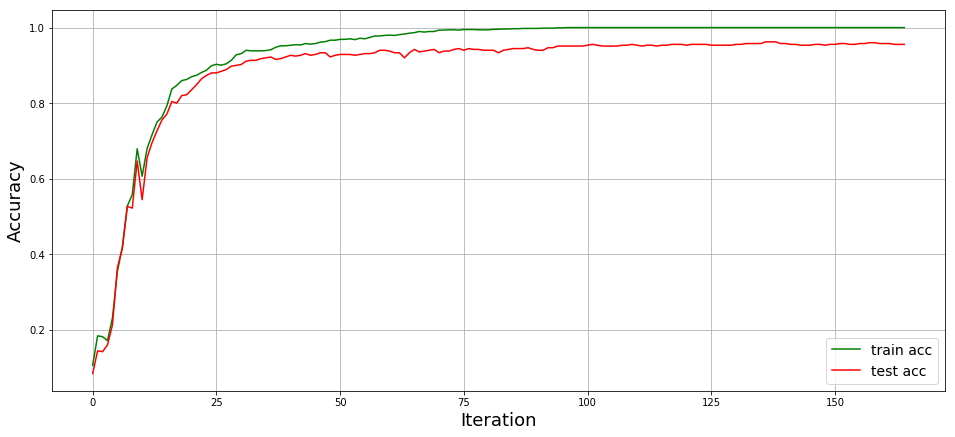

In [38]:
plt.figure(figsize=(16, 7))
plt.plot(cb.train_acc, color='g', label="train acc")
plt.plot(cb.test_acc, color='r', label="test acc")
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.legend(loc='lower right', prop={'size': 14})
plt.grid(True)
plt.show()

## Эксперименты с числом слоев (2 балла)

Ясно, что из-за случайного начального приближения с каждым запуском обучения мы будем получать различное качество. Попробуем обучать нашу нейросеть с разным числом слоев несколько раз.

Заполните матрицы accs_train и accs_test. В позиции [i, j] должна стоять величина точности сети с $i+1$ полносвязными слоями при $j$-м запуске (все запуски идентичны).

In [39]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))
success = np.zeros((5, 5))

In [40]:
### your code here
for n_layers in range(1, accs_train.shape[0] + 1):
    np.random.seed(my_seed)
    hidden_layers_size = 32
    
    for i in range(accs_train.shape[0]):
        if n_layers == 1:
            network = [Dense(X_train.shape[1], 10), Softmax()]
        else:
            network = [Dense(X_train.shape[1], hidden_layers_size), ReLU()]
            for j in range(n_layers - 2):
                network += [Dense(hidden_layers_size, hidden_layers_size), ReLU()]
            network += [Dense(hidden_layers_size, 10), Softmax()]
            
        weights = get_weights(network)
        res = minimize(compute_loss_grad, weights,
               args=[network, X_train, ohe_y_train],
               method="L-BFGS-B",
               jac=True)
        
        set_weights(res.x, network)
        y_pred_train = predict(network, X_train).argmax(1)
        y_pred_test = predict(network, X_test).argmax(1)
        accs_train[n_layers - 1, i] = accuracy_score(y_train, y_pred_train)
        accs_test[n_layers - 1, i] = accuracy_score(y_test, y_pred_test)
        success[n_layers - 1, i] = res.success

In [41]:
np.isnan(get_weights(network)).any()

False

In [42]:
success

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце - среднее, прямоугольник показывает разброс).

Text(0.5, 1.0, 'Test quality in 5 runs')

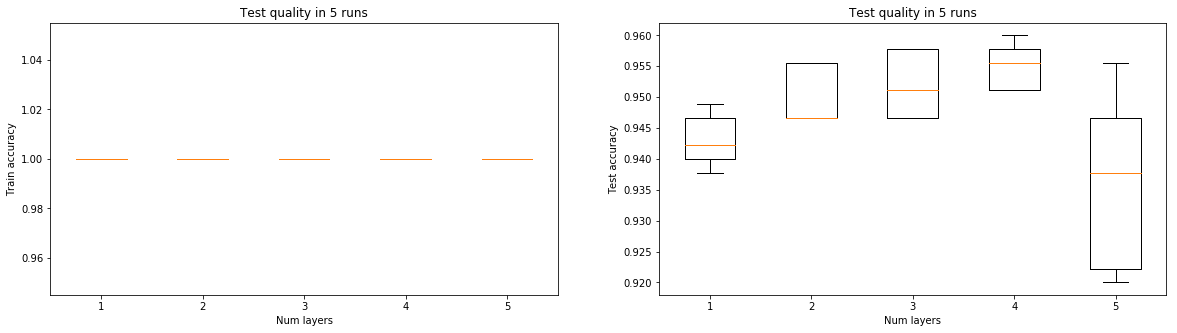

In [43]:
plt.subplots(figsize=(20, 5))
plt.subplot(121)
plt.boxplot(accs_train.T, showfliers=False)
plt.xlabel("Num layers")
plt.ylabel("Train accuracy")
plt.title("Test quality in 5 runs")
plt.subplot(122)
plt.boxplot(accs_test.T, showfliers=False)
plt.xlabel("Num layers")
plt.ylabel("Test accuracy")
plt.title("Test quality in 5 runs")

Ответьте на вопросы (кратко в этой же ячейке):
* Как изменяются качество на обучении и контроле и устойчивость процесса обучения при увеличении числа слоев?
* Можно ли сказать, что логистическая регрессия (линейная модель) дает качество хуже, чем нелинейная модель?

Ответы:
* Всё по стандарту: сначала качество растёт, так как модель дообучается, потом падает в связи с переобучением. При этом с увеличением количества слоёв сетка становится всё менее устойчивой (хотя на пяти запусках это не видно на сравнении количеств слоёв 4 и 5).
* Нет - это и теоретически ожидаемо (при более сложных разделяющих поверхностях нужна более сложная модель) и видно из эксперимента.

\* Несколько фрагментов кода в задании написаны на основе материалов [курса по глубинному обучению на ФКН НИУ ВШЭ](https://www.hse.ru/ba/ami/courses/205504078.html)

## Бонусная часть

## Реализация метода оптимизации (1 балл)

Реализуйте сами метод оптимизации (аналог функции minimize) для рассмотренной выше архитектуры. В качестве метода оптимизации используйте SGD + momentum. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с LBFGS-B. Сделайте выводы.

In [44]:
import scipy

In [45]:
def SGDM_minimize(fun, x0, args=(), alpha=0.1, eta=0.1, batch_frac=0.33, tol=1e-6, max_iter=1000, 
                  eval_set=None, callback=None):
    network, X, y = args
    
    train_size = X.shape[0]
    batch_size = int(train_size * batch_frac)
    max_epoch = int(max_iter / batch_frac)
    
    w = x0
    dw = 0
    loss_history = []
    acc_history = []
    for i in range(max_epoch):
        batch_idxs = np.random.choice(train_size, batch_size)
        loss, grad = fun(w, [network, X[batch_idxs], y[batch_idxs]])
        grad /= batch_size
        
        dw = alpha * dw - grad
        w = w + eta * dw
        
        loss, grad = fun(w, [network, X, y])
        loss_history.append(loss)
        if eval_set:
            set_weights(w, network)
            y_pred = predict(network, eval_set[0]).argmax(1)
            acc_history.append(accuracy_score(eval_set[1], y_pred))
            
        if callback:
            callback(w)
        
        if scipy.linalg.norm(dw) < tol:
            break
        
    if eval_set:
        return w, loss_history, acc_history
    else:
        return w, loss_history
        

In [46]:
network = []
hidden_layers_size = 32
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))
network.append(Softmax())

In [47]:
w0 = get_weights(network)

In [48]:
cb = Callback(network, X_train, y_train, X_test, y_test, ohe_y_train, print=False)
res = minimize(compute_loss_grad, w0,  
               args=[network, X_train, ohe_y_train], 
               method="L-BFGS-B",
               jac=True,
               callback=cb.call)

In [49]:
_, loss_history = SGDM_minimize(compute_loss_grad, w0, (network, X_train, ohe_y_train),
                                eta=0.1, alpha=0.1, batch_frac=0.2, max_iter=200)

Text(0.5, 1.0, 'L-BFGS-B')

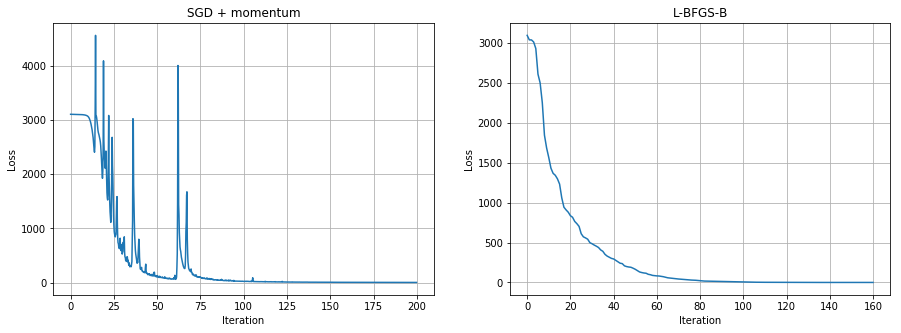

In [50]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(121)
plt.plot(np.arange(len(loss_history)) * 0.2, loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.title('SGD + momentum')

plt.subplot(122)
plt.plot(cb.loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.title('L-BFGS-B')

In [51]:
loss_history[-1], cb.loss[-1]

(3.530913969239812, 3.701105271147753e-07)

Сравнение: моя реализация градиентного спуска работает хуже - достигает не оптимального минимума, хотя достигает приемлимого качества за примерно то же количество итераций.

## Dropout (1 балл) 

Реализуйте слой Dropout. Сравните обучение сети из большого числа слоёв при использовании Dropout и без его использования (предварительно подберите адекватный параметр p). Сделайте выводы. Используя метод оптимизации из первого бонусного пункта. 

In [52]:
class Dropout:
    def __init__(self, p):
        self.params = []
        self.p = p
        self.choice = None
    
    def forward(self, input):
        self.choice = np.random.choice(2, input.shape[1], p=[self.p, 1-self.p])
        return input * self.choice / (1 - self.p)

    def backward(self, grad_output):
        grad_input = grad_output * self.choice / (1 - self.p)
        return grad_input, []

In [53]:
your_network = []
hidden_layers_size = 32
your_network.append(Dense(X_train.shape[1], hidden_layers_size))
your_network.append(ReLU())
your_network.append(Dense(hidden_layers_size, hidden_layers_size))
your_network.append(ReLU())
your_network.append(Dense(hidden_layers_size, hidden_layers_size))
your_network.append(ReLU())
your_network.append(Dense(hidden_layers_size, 10))
your_network.append(Softmax())
your_w0 = get_weights(your_network)

In [54]:
network_she_tells_you_not_to_worry_about = []
hidden_layers_size = 32
p = 0.5
network_she_tells_you_not_to_worry_about.append(Dense(X_train.shape[1], hidden_layers_size))
network_she_tells_you_not_to_worry_about.append(ReLU())
network_she_tells_you_not_to_worry_about.append(Dense(hidden_layers_size, hidden_layers_size))
network_she_tells_you_not_to_worry_about.append(ReLU())
network_she_tells_you_not_to_worry_about.append(Dropout(p))
network_she_tells_you_not_to_worry_about.append(Dense(hidden_layers_size, hidden_layers_size))
network_she_tells_you_not_to_worry_about.append(ReLU())
network_she_tells_you_not_to_worry_about.append(Dense(hidden_layers_size, 10))
network_she_tells_you_not_to_worry_about.append(Softmax())
other_w0 = get_weights(network_she_tells_you_not_to_worry_about)

In [63]:
_, your_loss_history, your_acc = SGDM_minimize(compute_loss_grad, your_w0, (your_network, X_train, ohe_y_train), 
                                               eta=0.1, alpha=0.1, batch_frac=0.3, max_iter=750, eval_set=(X_test, y_test))

In [60]:
dropout_off = [layer for layer in network_she_tells_you_not_to_worry_about if type(layer) is not Dropout]
dropout_off_acc = []
def callback(w):
    set_weights(w, dropout_off)
    y_pred = predict(dropout_off, X_test).argmax(1)
    dropout_off_acc.append(accuracy_score(y_test, y_pred))

In [64]:
_, other_loss_history, other_acc = SGDM_minimize(compute_loss_grad, other_w0, (network_she_tells_you_not_to_worry_about, 
                                                                               X_train, ohe_y_train), 
                                               eta=0.1, alpha=0.1, batch_frac=0.3, max_iter=750, 
                                                 eval_set=(X_test, y_test), callback=callback)

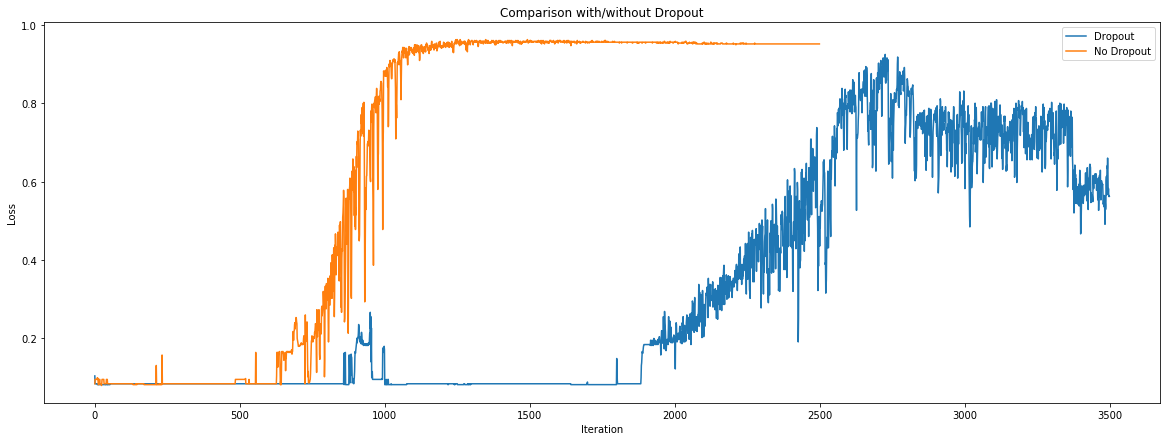

In [65]:
plt.figure(figsize=(20, 7))

plt.plot(dropout_off_acc, label='Dropout')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()

plt.plot(your_acc, label='No Dropout')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()

plt.title('Comparison with/without Dropout')
plt.legend()

По какой-то причине сеть с дропаутом обучается слишком нестабильно и медленно - постоянно забывает всё, чему научилась и доля правильных ответов не выходит на плато. Всё-таки думаю, что написанный мной алгоритм минимизации не подходит для этого - проблема именно в постоянном забывании. Возможно, здесь больше поможет "шагать назад", когда качество падает слишком сильно.

## BatchNormalization (1 балл)

Реализуйте слой BatchNormalization. Сравните обучение сети из большого числа слоёв при использовании BatchNormalization и без его использования.  Сделайте выводы. Используя метод оптимизации из первого бонусного пункта. 